In [1]:
import shutil
shutil.copy("/content/drive/MyDrive/CDU/Retractions/retractions35215.csv", "./")

'./retractions35215.csv'

In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
df =pd.read_csv("/content/retractions35215.csv")

In [4]:
df.columns

Index(['Record ID', 'Title', 'Subject', 'Institution', 'Journal', 'Publisher',
       'Country', 'Author', 'URLS', 'ArticleType', 'RetractionDate',
       'RetractionDOI', 'RetractionPubMedID', 'OriginalPaperDate',
       'OriginalPaperDOI', 'OriginalPaperPubMedID', 'RetractionNature',
       'Reason', 'Paywalled', 'Notes', 'CitationCount'],
      dtype='object')

In [5]:
df.head()

Record ID                                              Title  \
0      50792  A fractional order nonlinear model of the love...   
1      50782  Investigation of automotive digital mirrors er...   
2      50781  Optical spectroscopic analysis of bandpass fil...   
3      50731  THz Design Variable Estimation by Deep Optimiz...   
4      50727  A Study on Glycyrrhiza glabra-Fortified Bread:...   

                                             Subject  \
0              (B/T) Data Science;(PHY) Mathematics;   
1                    (PHY) Engineering - Mechanical;   
2  (PHY) Chemistry;(PHY) Crystallography/Spectros...   
3           (B/T) Computer Science;(B/T) Technology;   
4  (BLS) Biochemistry;(ENV) Food Science;(HSC) Nu...   

                                         Institution  \
0  Department of Mathematical Sciences, College o...   
1  Department of Physics, Faculty of Science, Cai...   
2  Egypt Nanotechnology Center ((EGNC)), Cairo Un...   
3  School of Computing Science and Engineering, V...   
4  Department of Mechanical Engineering, Aarupada...   

                                   Journal  \
0                       Scientific Reports   
1                Journal of Optics (India)   
2                Journal of Optics (India)   
3  Terahertz Devices, Circuits and Systems   
4  Bioinorganic Chemistry and Applications   

                            Publisher                Country  \
0  Springer - Nature Publishing Group   United Arab Emirates   
1                            Springer                  Egypt   
2                            Springer                  Egypt   
3                            Springer                  India   
4                             Hindawi  Ethiopia;India;Turkey   

                                              Author  \
0                    Zulqurnain Sabir;Salem Ben Said   
1            H S Ayoub;Wessam M Hussein;Y H Elbashar   
2  Y H Elbashar;M A Mohamed;D Rayan;A M Badr;H A ...   
3  L Sathish Kumar;B Sathish Kumar;A Padmapriya;S...   
4  M Prabhahar;Gomathi Kannayiram;Prakash Sekar;S...   

                                                URLS  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  https://retractionwatch.com/2022/09/28/exclusi...   

                    ArticleType  ...                 RetractionDOI  \
0             Research Article;  ...    10.1038/s41598-024-51277-3   
1             Research Article;  ...    10.1007/s12596-023-01630-y   
2             Research Article;  ...    10.1007/s12596-023-01628-6   
3  Book Chapter/Reference Work;  ...  10.1007/978-981-19-4105-4_15   
4             Research Article;  ...          10.1155/2023/9828939   

  RetractionPubMedID  OriginalPaperDate              OriginalPaperDOI  \
0         38191570.0          3/04/2023    10.1038/s41598-023-32497-5   
1                0.0         12/01/2021    10.1007/s12596-021-00677-z   
2                0.0          5/05/2020    10.1007/s12596-020-00611-9   
3                0.0         27/09/2022  10.1007/978-981-19-4105-4_15   
4         37621328.0         30/08/2022          10.1155/2022/4669723   

  OriginalPaperPubMedID  RetractionNature  \
0            37012356.0        Retraction   
1                   0.0        Retraction   
2                   0.0        Retraction   
3                   0.0        Retraction   
4            36082190.0        Retraction   

                                              Reason Paywalled  \
0  +Duplication of Article;+Euphemisms for Duplic...        No   
1  +Fake Peer Review;+Investigation by Journal/Pu...        No   
2  +Concerns/Issues with Peer Review;+Fake Peer R...        No   
3  +Date of Retraction/Other Unknown;+Euphemisms ...        No   
4  +Concerns/Issues About Data;+Concerns/Issues A...        No   

                                               Notes CitationC

**Data Cleaning and Preprocessing**

In [6]:
columns_to_drop = ['Record ID', 'URLS', 'OriginalPaperDOI', 'RetractionDOI', 'RetractionPubMedID',
                   'OriginalPaperPubMedID', 'Title', 'Institution', 'Notes']
df.drop(columns=columns_to_drop, inplace=True)

df.dropna(subset=['Paywalled'], inplace=True)

print("Shape after Dropping Columns and Null Values:", df.shape)
print("Duplicated Rows after Dropping:", df.duplicated().sum())
print("Null Values after Dropping:\n", df.isnull().sum())

duplicate_entries = df[df.duplicated(keep=False)]
print("First 5 Duplicate Entries:\n", duplicate_entries.head(5))

df['OriginalPaperDate'] = pd.to_datetime(df['OriginalPaperDate'], dayfirst=True, errors='coerce')
df['RetractionDate'] = pd.to_datetime(df['RetractionDate'], dayfirst=True, errors='coerce')

df['TimeDifference_Days'] = (df['RetractionDate'] - df['OriginalPaperDate']).dt.days

df['Retraction_to_Citation_Ratio'] = df.apply(lambda row: row['TimeDifference_Days'] / row['CitationCount'] if row['CitationCount'] != 0 else float('inf'), axis=1)

df['Citation_to_Retraction_Ratio'] = df.apply(lambda row: row['CitationCount'] / row['TimeDifference_Days'] if row['TimeDifference_Days'] != 0 else float('inf'), axis=1)

def transform_subject(subject):
    codes = re.findall(r'\((.*?)\)', subject)
    return ', '.join(sorted(set(codes)))

df['Subject'] = df['Subject'].apply(transform_subject)

Shape after Dropping Columns and Null Values: (35213, 12)
Duplicated Rows after Dropping: 29
Null Values after Dropping:
 Subject              0
Journal              0
Publisher            0
Country              0
Author               0
ArticleType          0
RetractionDate       0
OriginalPaperDate    0
RetractionNature     0
Reason               0
Paywalled            0
CitationCount        0
dtype: int64
First 5 Duplicate Entries:
                                                  Subject  \
6782   (HSC) Medicine - Diabetes;(HSC) Medicine - Uro...   
6783   (HSC) Medicine - Diabetes;(HSC) Medicine - Uro...   
12219                    (PHY) Engineering - Electrical;   
12220                    (PHY) Engineering - Electrical;   
13302                            (B/T) Computer Science;   

                                                 Journal  \
6782   Nephrology, Dialysis, Transplantation: Officia...   
6783   Nephrology, Dialysis, Transplantation: Officia...   
12219  Electrical En

**Exploratory Data Analysis**

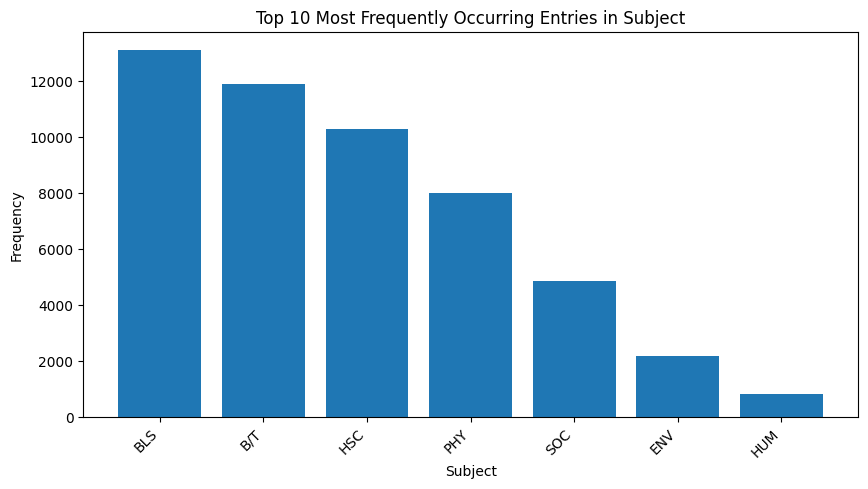

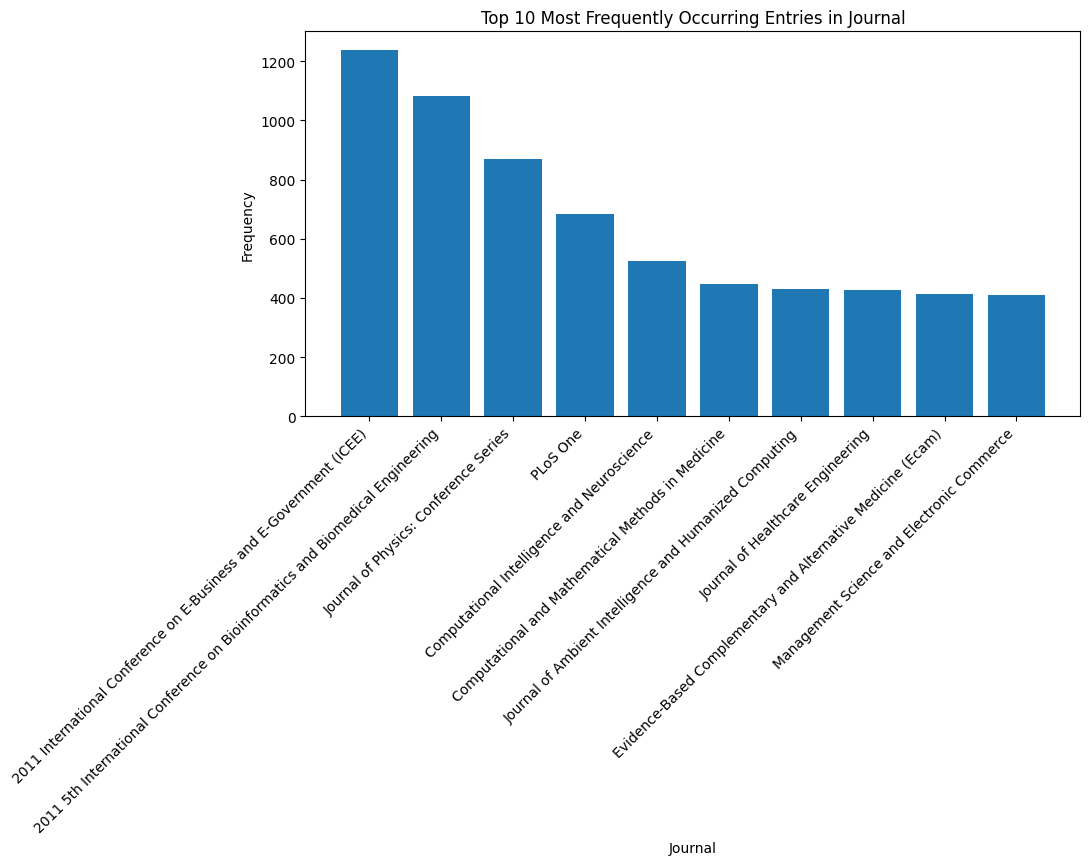

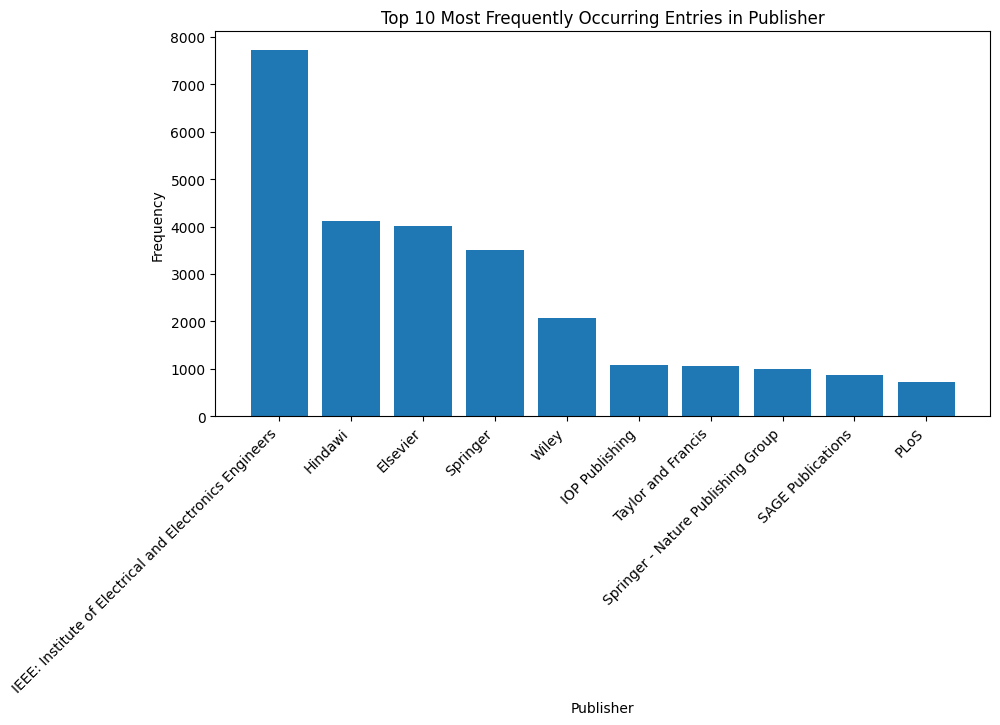

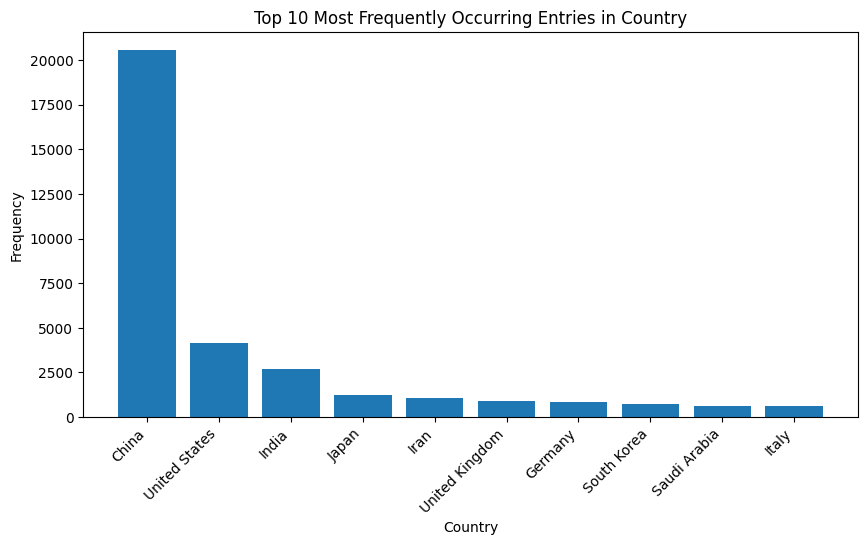

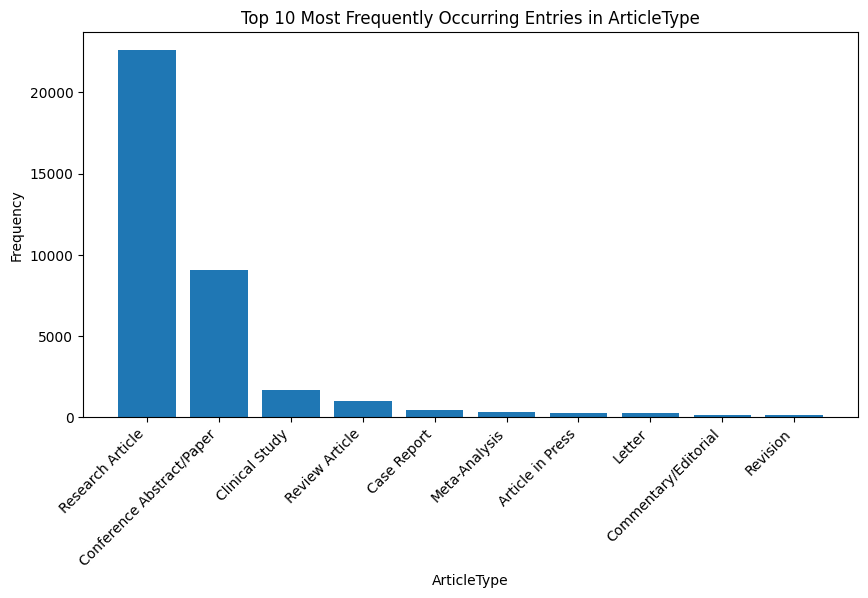

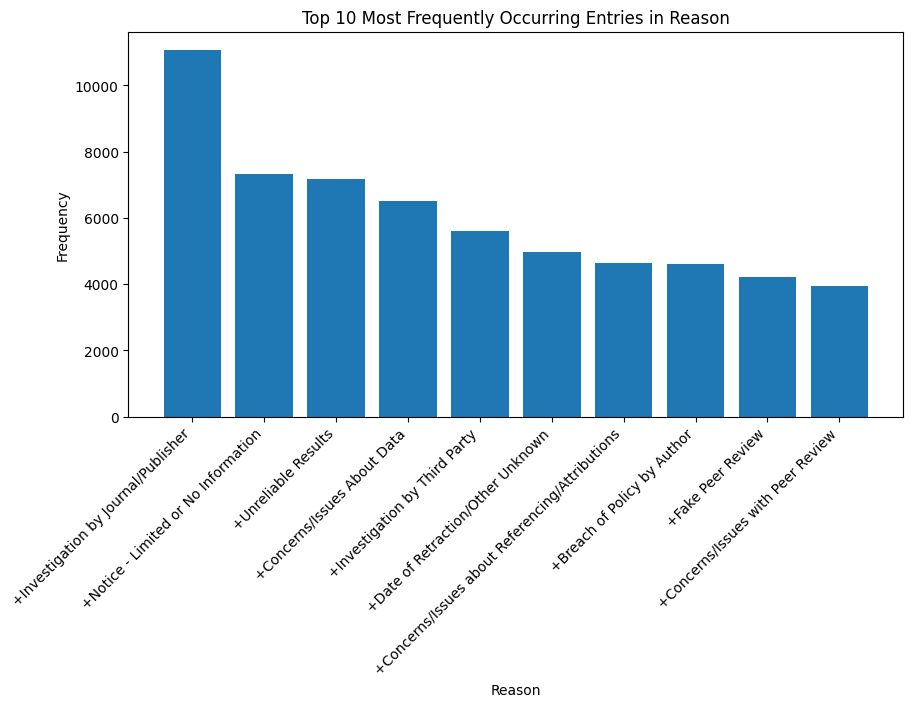

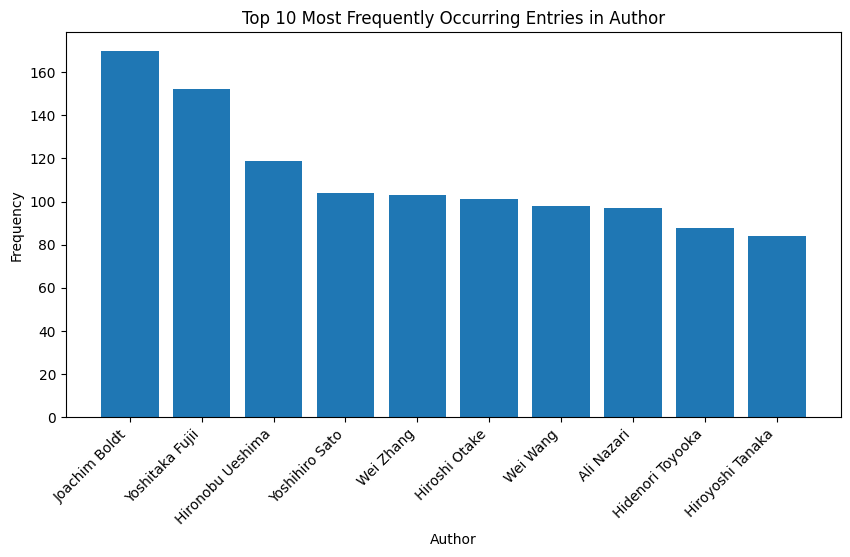

In [7]:
######### Occurrences Analysis #################################

columns_to_analyze = ['Subject', 'Journal', 'Publisher', 'Country', 'ArticleType', 'Reason','Author']

def count_occurrences(column):
    occurrences = {}
    for cell in df[column].dropna():
        entries = re.split(r'[;,]', cell)
        for entry in entries:
            entry = entry.strip()
            if entry:
                if entry in occurrences:
                    occurrences[entry] += 1
                else:
                    occurrences[entry] = 1
    return occurrences

def plot_top_10(column):
    occurrences = count_occurrences(column)
    sorted_occurrences = dict(sorted(occurrences.items(), key=lambda item: item[1], reverse=True)[:10])
    plt.figure(figsize=(10, 5))
    plt.bar(sorted_occurrences.keys(), sorted_occurrences.values())
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Most Frequently Occurring Entries in {column}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

for column in columns_to_analyze:
    plot_top_10(column)


Top 20 values in Reason:
+Investigation by Journal/Publisher                11072
+Notice - Limited or No Information                 7319
+Unreliable Results                                 7169
+Concerns/Issues About Data                         6514
+Investigation by Third Party                       5602
+Date of Retraction/Other Unknown                   4960
+Concerns/Issues about Referencing/Attributions     4631
+Breach of Policy by Author                         4623
+Fake Peer Review                                   4209
+Concerns/Issues with Peer Review                   3939
+Duplication of Image                               3437
+Concerns/Issues About Results                      2477
+Paper Mill                                         2442
+Investigation by Company/Institution               2365
+Randomly Generated Content                         2084
+Duplication of Article                             2032
+Plagiarism of Article                              1807
+With

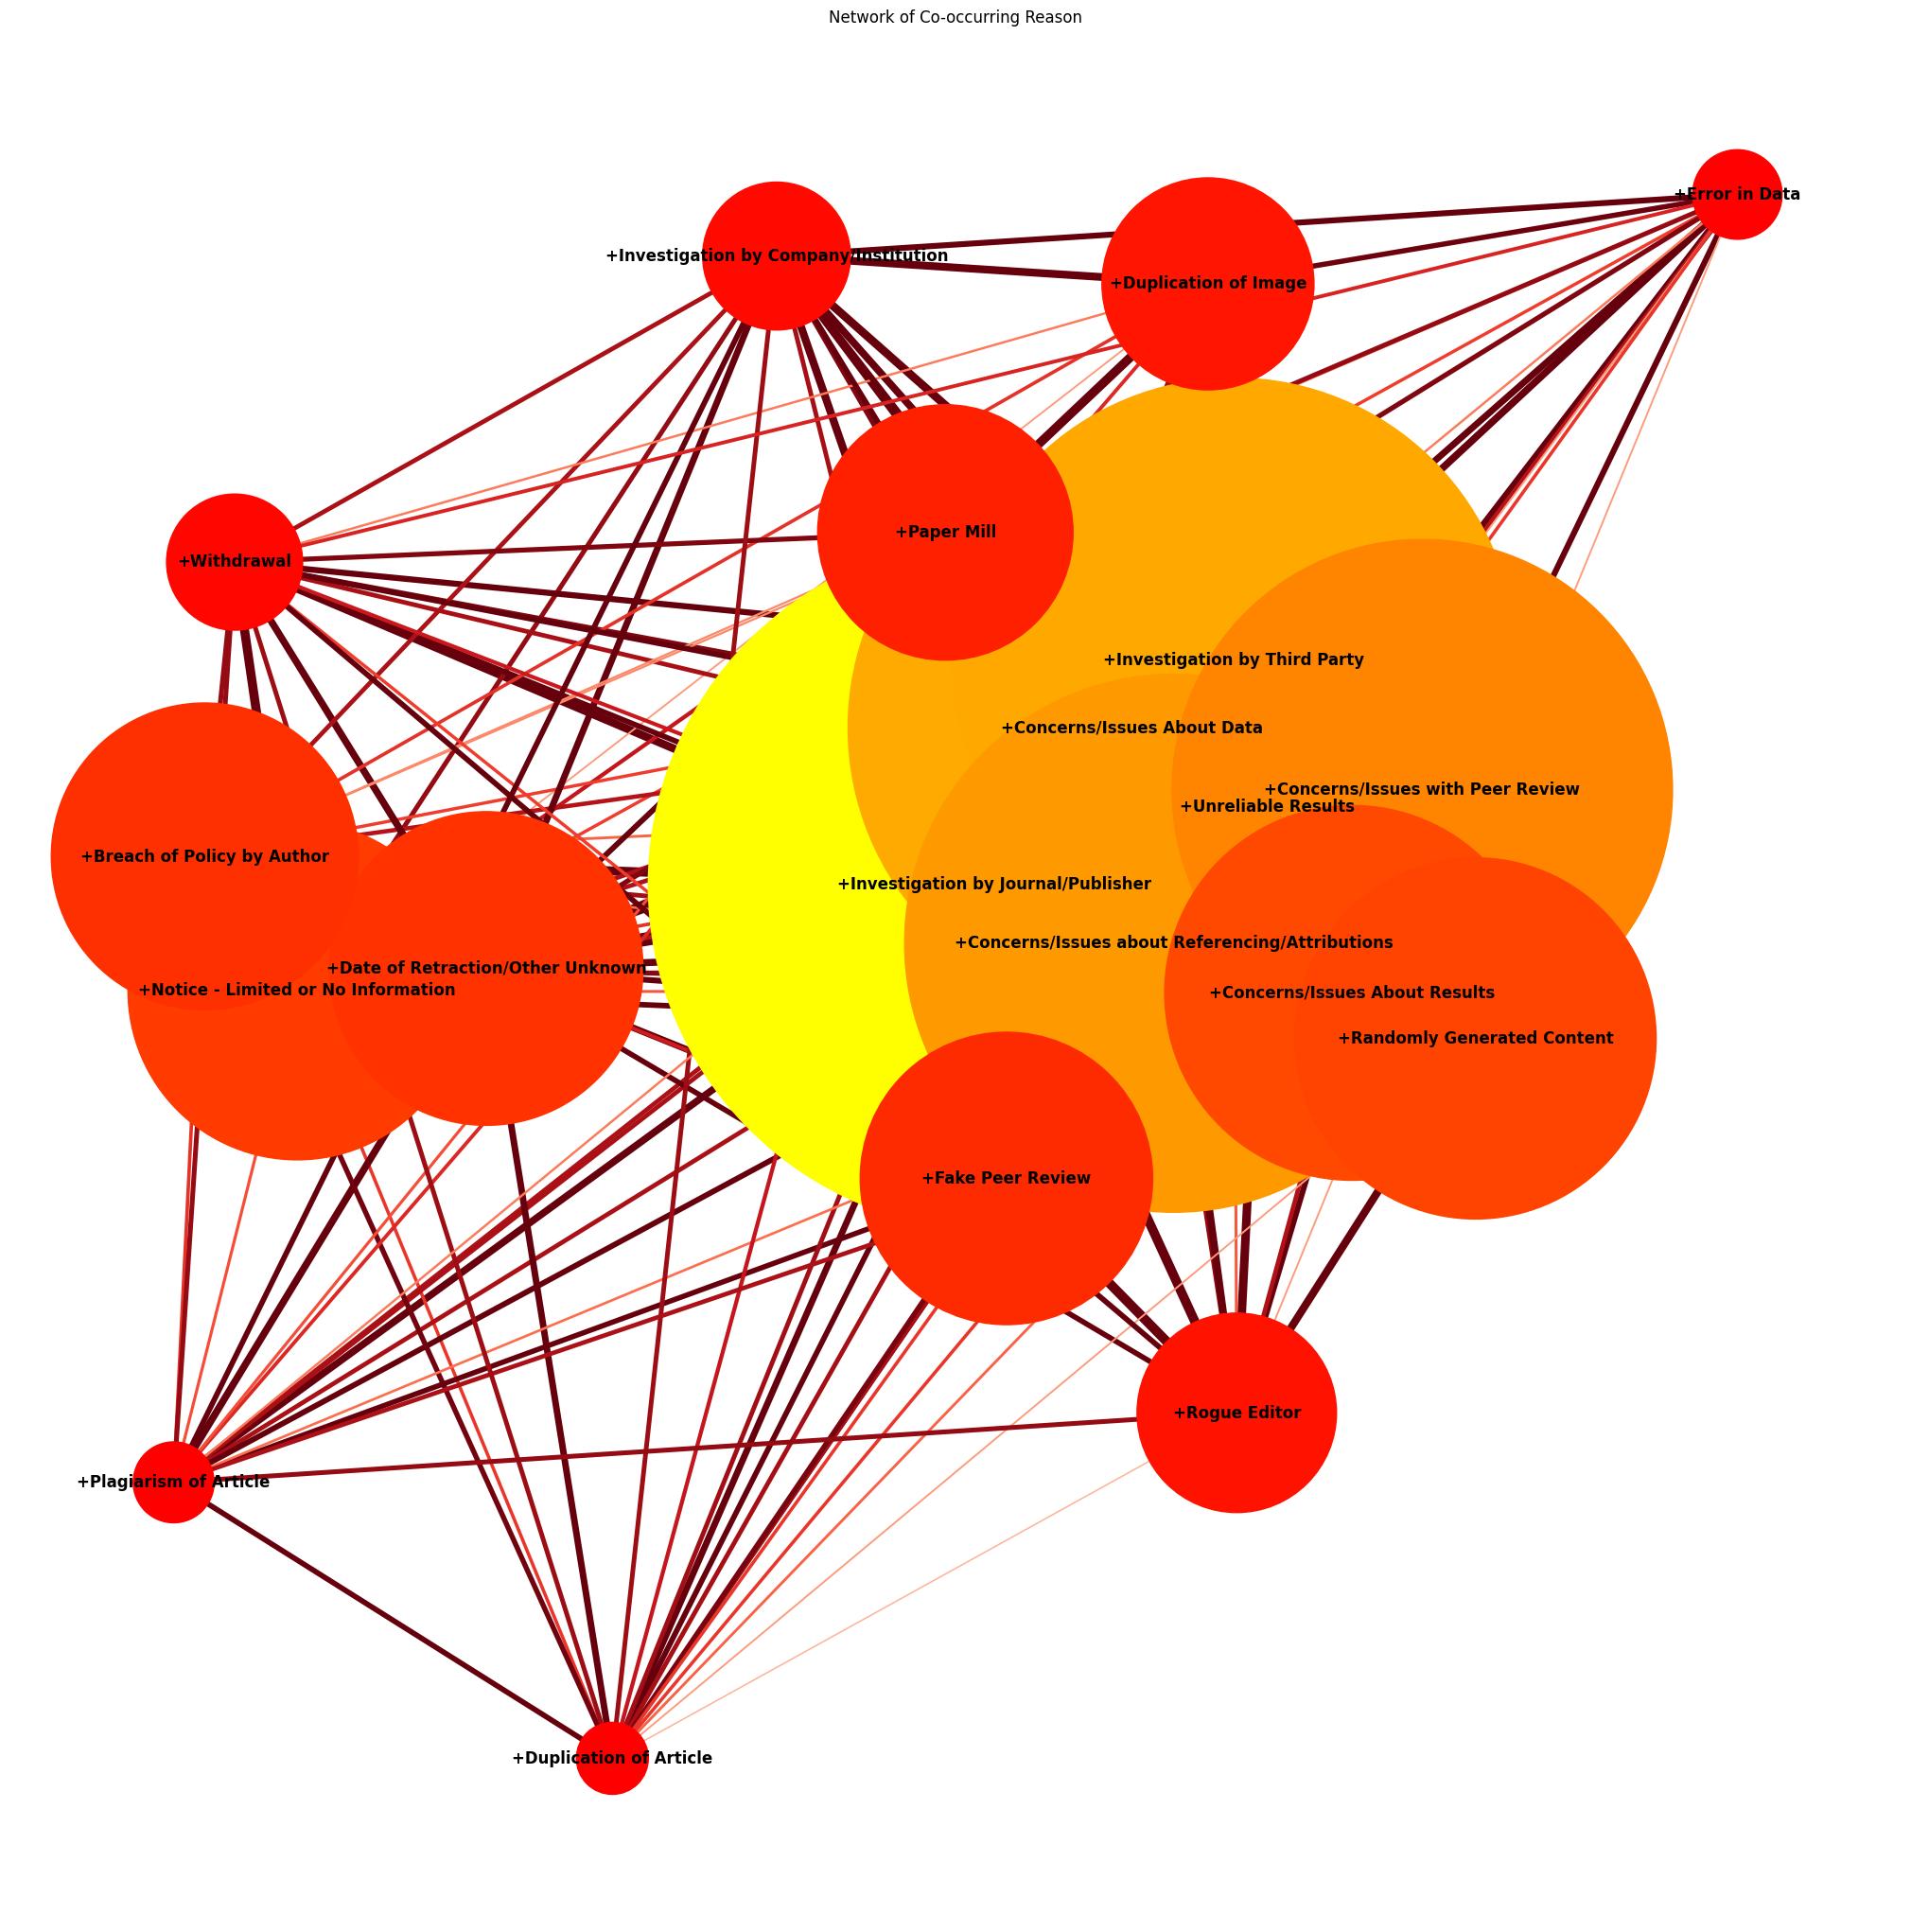


Top 1 values in Author:
Joachim Boldt    170
Name: count, dtype: int64

Initial correlation matrix for Author (first 5 rows and columns):
               Joachim Boldt
Joachim Boldt            0.0

Reduced correlation matrix for Author after applying drop_thresh of 1 (first 5 rows and columns):
Empty DataFrame
Columns: []
Index: []
Empty reduced correlation matrix for Author. Skipping...

Top all values in Subject:
BLS                   6716
B/T                   4777
BLS, HSC              4631
PHY                   4262
HSC                   3583
                      ... 
B/T, BLS, HUM, SOC       1
B/T, HSC, HUM, PHY       1
BLS, ENV, HSC, HUM       1
B/T, HSC, HUM, SOC       1
HSC, HUM, PHY            1
Name: count, Length: 79, dtype: int64

Initial correlation matrix for Subject (first 5 rows and columns):
          BLS  B/T  BLS, HSC  PHY  HSC
BLS       0.0  0.0       0.0  0.0  0.0
B/T       0.0  0.0       0.0  0.0  0.0
BLS, HSC  0.0  0.0       0.0  0.0  0.0
PHY       0.0  0.0    

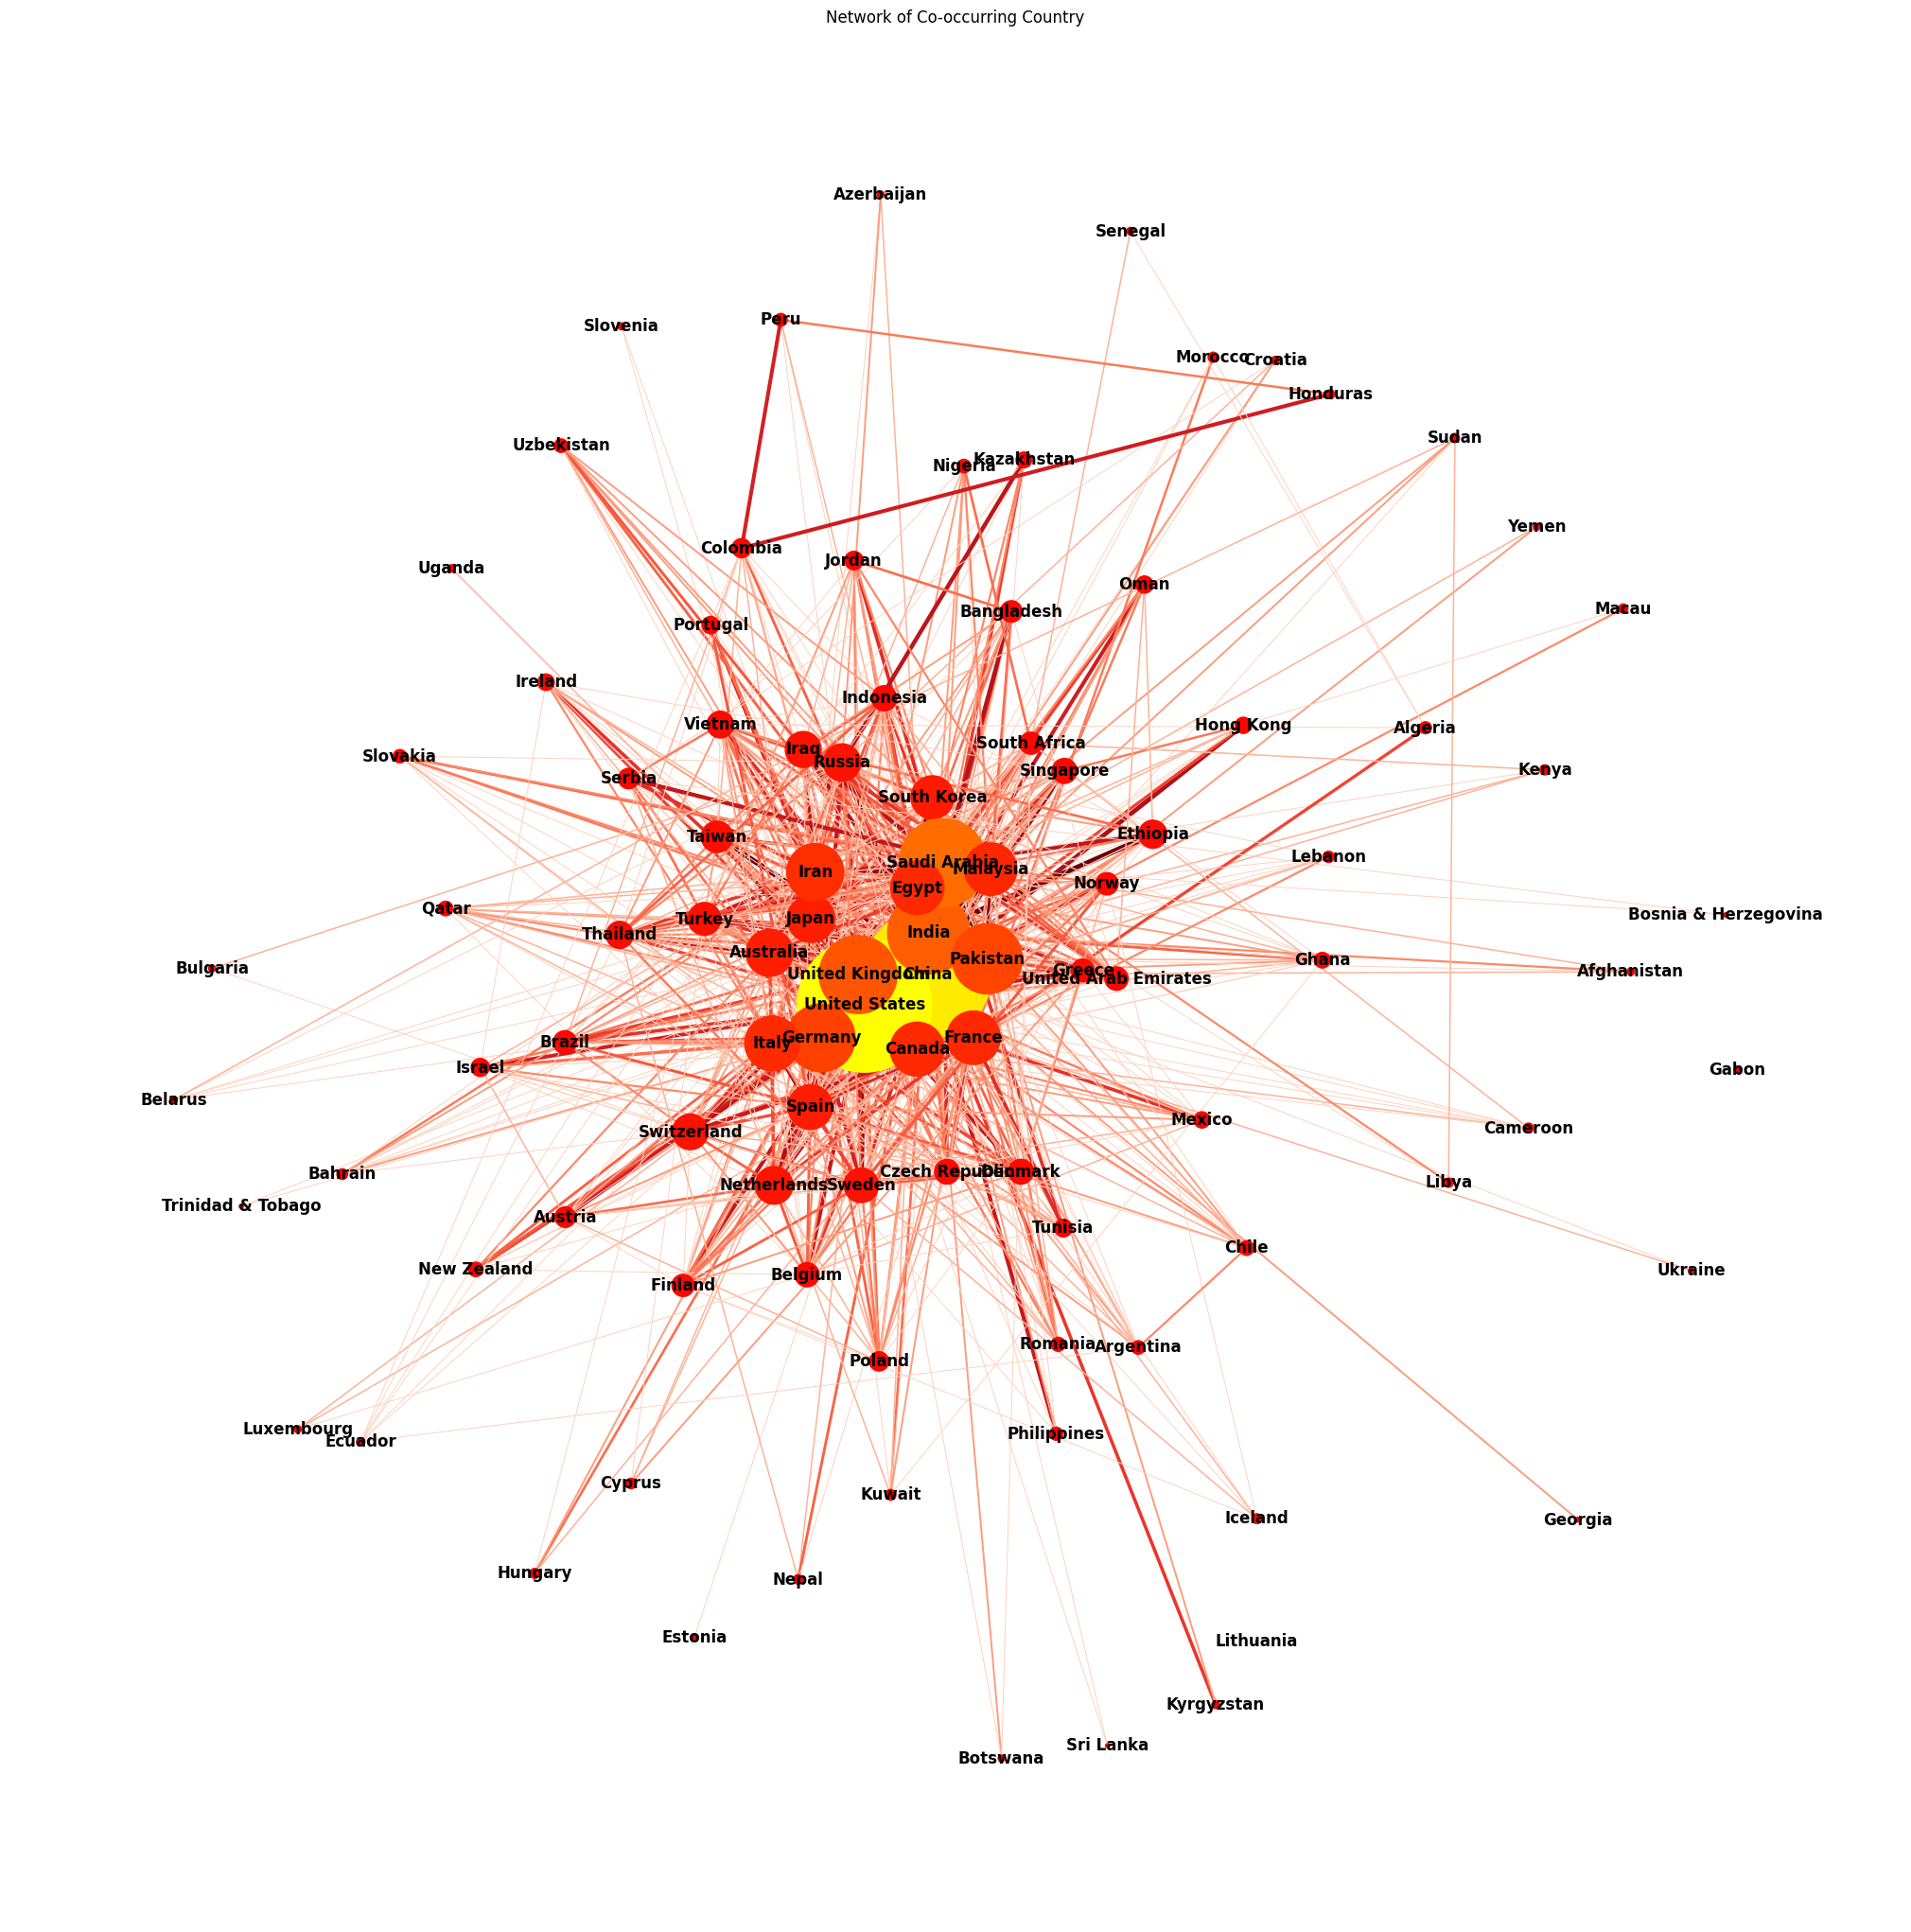

In [9]:
######### Network Graph Analysis ##############################

def display_network_graph(column_name, top_n=None, weighted_degree_thresh=1, drop_thresh=5):
    all_vals = ";".join(list(df[column_name].dropna())).split(";")
    all_vals = [vv.strip() for vv in all_vals if vv not in ["", "Unknown", "unavailable", "Unavailable", "No affiliation available"]]
    all_vals_series = pd.Series(all_vals)
    top_rank = all_vals_series.value_counts().sort_values(ascending=False)

    if top_n is not None:
        more_than_1 = list(top_rank.head(top_n).index)
    else:
        more_than_1 = list(top_rank.index)

    print(f"\nTop {top_n if top_n is not None else 'all'} values in {column_name}:")
    print(top_rank.head(top_n if top_n is not None else len(top_rank)))

    if len(more_than_1) == 0:
        print(f"No entries for {column_name}. Skipping...")
        return

    aa_cor_mat = pd.DataFrame(np.zeros((len(more_than_1), len(more_than_1))), columns=more_than_1, index=more_than_1)

    column_lists = list(df[column_name].dropna().str.split(";"))
    for cl in column_lists:
        cl = [item.strip() for item in cl]  # Ensure all items are stripped
        for ii in range(len(cl)):
            if cl[ii] not in more_than_1:
                continue
            for jj in range(ii + 1, len(cl)):
                if cl[jj] not in more_than_1:
                    continue
                aa_cor_mat.loc[cl[ii], cl[jj]] += 1
                aa_cor_mat.loc[cl[jj], cl[ii]] += 1

    print(f"\nInitial correlation matrix for {column_name} (first 5 rows and columns):")
    print(aa_cor_mat.iloc[:5, :5])

    aa_cor_mat_reduced = aa_cor_mat.copy()
    for au in aa_cor_mat.columns:
        if aa_cor_mat[au].sum() < drop_thresh:
            aa_cor_mat_reduced = aa_cor_mat_reduced.drop(columns=[au])
            aa_cor_mat_reduced = aa_cor_mat_reduced.drop(index=[au])

    print(f"\nReduced correlation matrix for {column_name} after applying drop_thresh of {drop_thresh} (first 5 rows and columns):")
    print(aa_cor_mat_reduced.iloc[:5, :5])

    if aa_cor_mat_reduced.shape[0] == 0 or aa_cor_mat_reduced.shape[1] == 0:
        print(f"Empty reduced correlation matrix for {column_name}. Skipping...")
        return

    G = nx.from_pandas_adjacency(aa_cor_mat_reduced)

    high_degree_nodes = [node for node, degree in G.degree(weight="weight") if degree > weighted_degree_thresh]
    G = G.subgraph(high_degree_nodes)

    print(f"\nNodes in the final graph for {column_name}: {len(G.nodes())}")
    print(list(G.nodes())[:5])  # Print first 5 nodes as a sample

    print(f"\nEdges in the final graph for {column_name}: {len(G.edges())}")
    print(list(G.edges(data=True))[:5])  # Print first 5 edges as a sample

    if len(high_degree_nodes) == 0:
        print(f"No high degree nodes for {column_name} after threshold filtering. Skipping...")
        return

    degrees = dict(G.degree())
    weighted_degrees = dict(G.degree(weight='weight'))

    print(f"\nDegree of nodes in the final graph for {column_name} (first 5):")
    print({k: degrees[k] for k in list(degrees)[:5]})  # Print first 5 degrees as a sample

    print(f"\nWeighted degree of nodes in the final graph for {column_name} (first 5):")
    print({k: weighted_degrees[k] for k in list(weighted_degrees)[:5]})  # Print first 5 weighted degrees as a sample

    highest_weighted_degree_node = max(weighted_degrees, key=weighted_degrees.get)
    print(f"\nNode with the highest weighted degree in the final graph for {column_name}:")
    print(f"{highest_weighted_degree_node}: {weighted_degrees[highest_weighted_degree_node]}")

    edge_weights = [np.log(data['weight']) for _, _, data in G.edges(data=True)]
    normalized_edge_weights = edge_weights
    degs = [d[1]**1.2 for d in G.degree(weight="weight")]

    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=1.8)
    node_colors = range(len(G.nodes()))
    edge_colors = range(len(G.edges()))
    nx.draw(G, with_labels=True, pos=pos, font_weight='bold', edge_color=normalized_edge_weights, width=normalized_edge_weights, edge_cmap=plt.cm.Reds, edge_vmin=0, edge_vmax=4, node_size=degs, node_color=degs, cmap=plt.cm.autumn)
    plt.title(f"Network of Co-occurring {column_name}")
    plt.show()

params = {
    'Reason': {'top_n': 20, 'weighted_degree_thresh': 1, 'drop_thresh': 5},
    'Author': {'top_n': 1, 'weighted_degree_thresh': 1, 'drop_thresh': 1},
    'Subject': {'top_n': None, 'weighted_degree_thresh': 1, 'drop_thresh': 3},  # Include all subjects
    'Country': {'top_n': 100, 'weighted_degree_thresh': 1, 'drop_thresh': 2}
}

columns_to_analyze = ['Reason', 'Author', 'Subject', 'Country']
for column in columns_to_analyze:
    display_network_graph(column, **params[column])


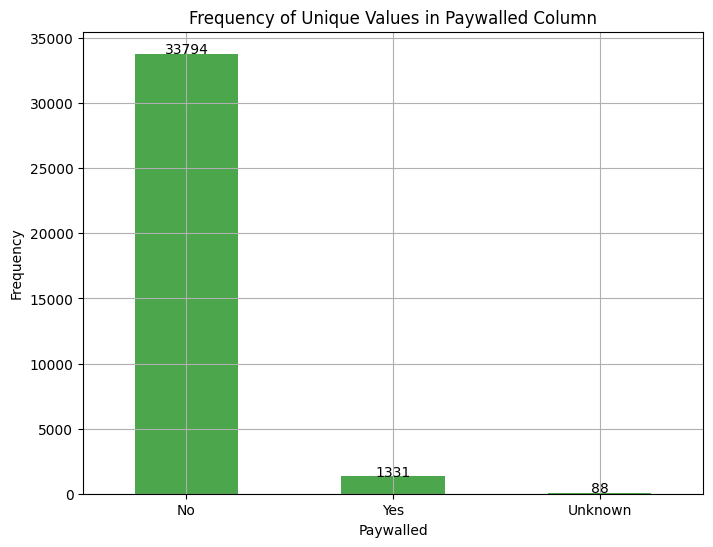

In [10]:
######### Paywalled plot ########################

retractions_by_paywalled = df['Paywalled'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
retractions_by_paywalled.plot(kind='bar', ax=ax, color='green', alpha=0.7)
ax.set_ylabel('Frequency')
ax.set_xlabel('Paywalled')
ax.set_title('Frequency of Unique Values in Paywalled Column')
ax.set_xticklabels(retractions_by_paywalled.index, rotation=0)
for i in range(len(retractions_by_paywalled)):
    ax.text(i, retractions_by_paywalled[i] + 5, str(retractions_by_paywalled[i]), ha='center', color='black')
plt.grid(True)
plt.show()

<Figure size 1500x1000 with 0 Axes>

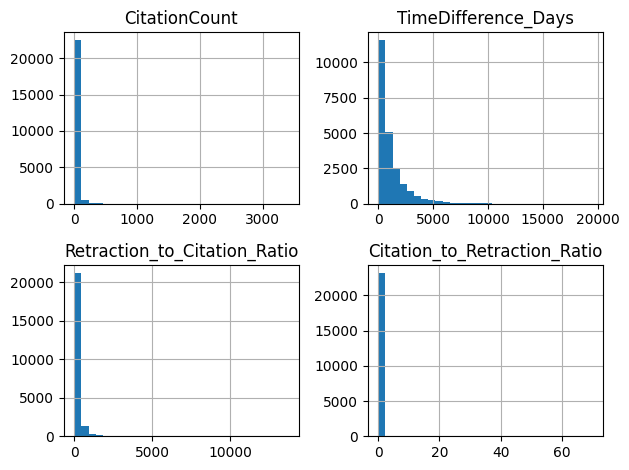

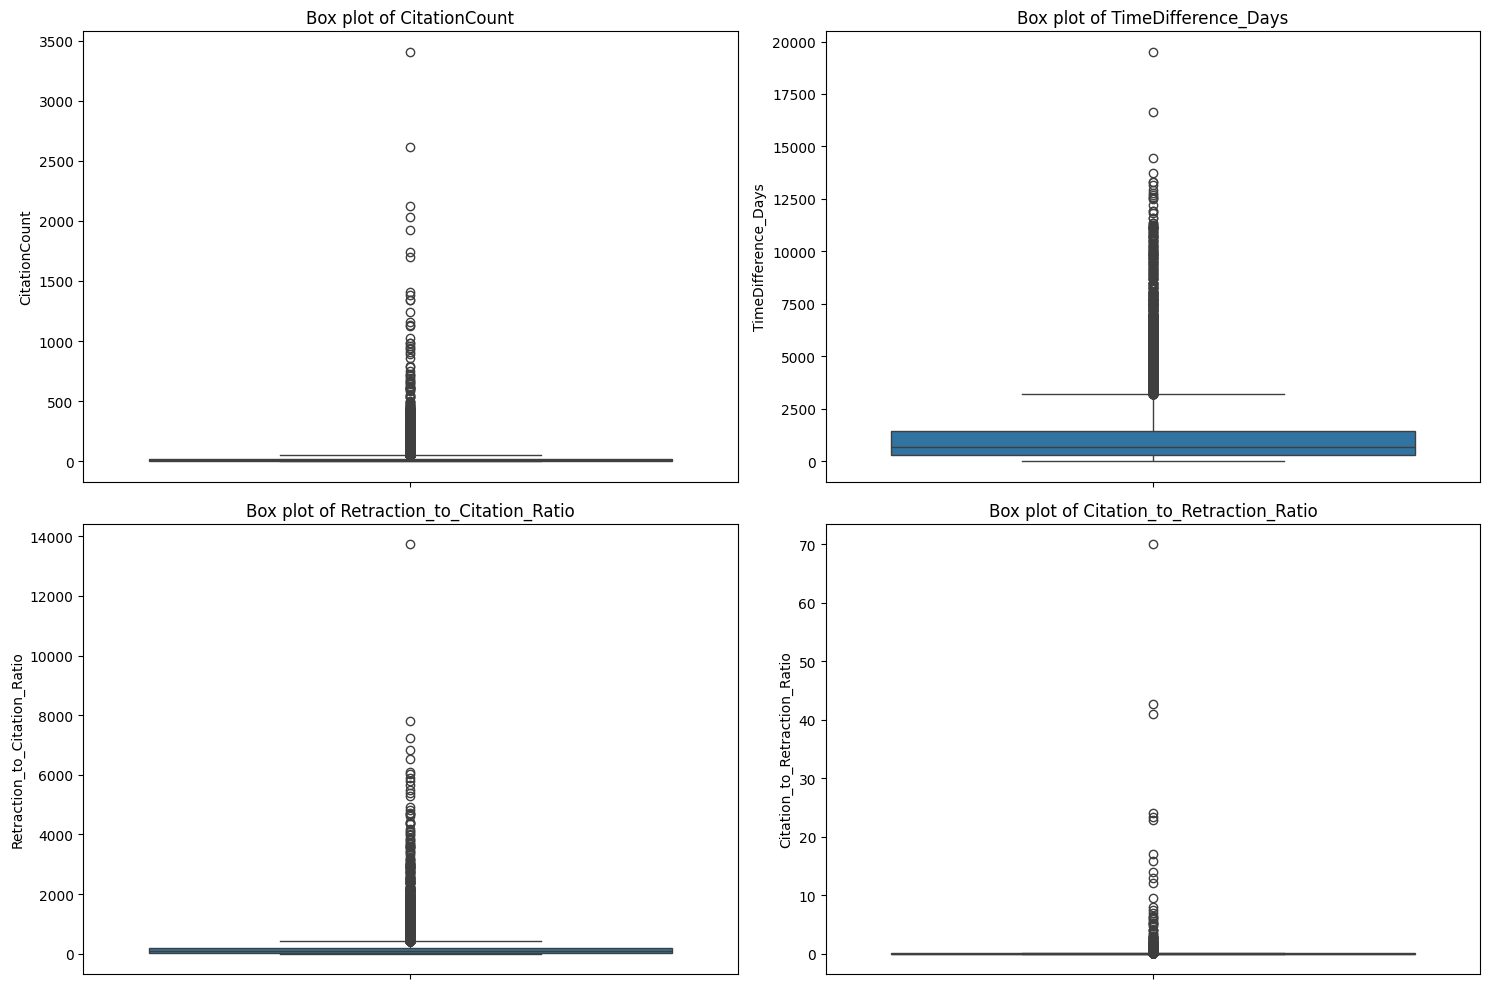

In [11]:
######### Distribution Analysis ########################

df['Retraction_to_Citation_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['Citation_to_Retraction_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

df_filtered = df.dropna(subset=['Retraction_to_Citation_Ratio', 'Citation_to_Retraction_Ratio'])

plt.figure(figsize=(15, 10))
df_filtered[['CitationCount', 'TimeDifference_Days', 'Retraction_to_Citation_Ratio', 'Citation_to_Retraction_Ratio']].hist(bins=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, column in enumerate(['CitationCount', 'TimeDifference_Days', 'Retraction_to_Citation_Ratio', 'Citation_to_Retraction_Ratio'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(df_filtered[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

In [12]:
######### Summary Statistics ##################################

summary_stats = df.describe()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
                       RetractionDate              OriginalPaperDate  \
count                          35213                          35213   
mean   2017-05-12 08:12:41.446056960  2015-01-23 11:04:29.184676096   
min              1940-12-01 00:00:00            1940-12-01 00:00:00   
25%              2011-08-18 00:00:00            2011-04-22 00:00:00   
50%              2019-03-01 00:00:00            2015-07-25 00:00:00   
75%              2022-07-04 00:00:00            2020-07-08 00:00:00   
max              2024-01-09 00:00:00            2023-10-01 00:00:00   
std                              NaN                            NaN   

       CitationCount  TimeDifference_Days  Retraction_to_Citation_Ratio  \
count   35213.000000         35213.000000                  23655.000000   
mean       15.556045           839.880697                    173.817838   
min         0.000000             0.000000                      0.000000   
25%         0.000000            79.0000

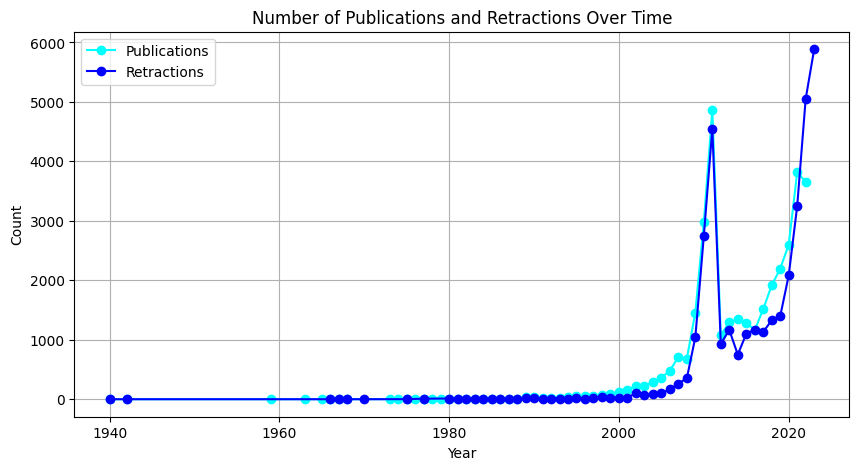

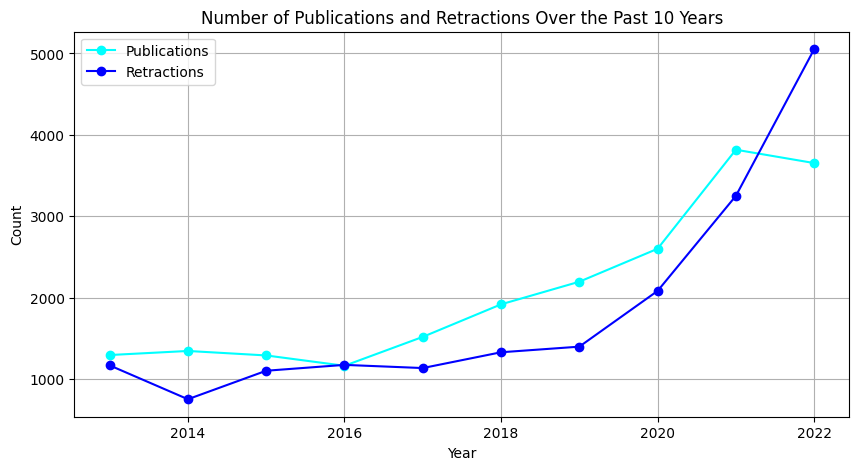

In [13]:
######### Time Series Analysis ########################

df_filtered = df[df['RetractionDate'].dt.year < 2024]
df_filtered = df_filtered[df_filtered['OriginalPaperDate'].dt.year < 2023]

df_filtered['Year_Retraction'] = df_filtered['RetractionDate'].dt.year
retractions_by_year = df_filtered['Year_Retraction'].value_counts().sort_index()

df_filtered['Year_Publication'] = df_filtered['OriginalPaperDate'].dt.year
publications_by_year = df_filtered['Year_Publication'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.plot(publications_by_year.index, publications_by_year.values, label='Publications', color='cyan', marker='o')
plt.plot(retractions_by_year.index, retractions_by_year.values, label='Retractions', color='blue', marker='o')
plt.title('Number of Publications and Retractions Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

common_recent_years = retractions_by_year.index.intersection(publications_by_year.index)
common_recent_years = common_recent_years.sort_values()[-10:]

retractions_recent = retractions_by_year.loc[common_recent_years]
publications_recent = publications_by_year.loc[common_recent_years]

plt.figure(figsize=(10, 5))
plt.plot(publications_recent.index, publications_recent.values, label='Publications', color='cyan', marker='o')
plt.plot(retractions_recent.index, retractions_recent.values, label='Retractions', color='blue', marker='o')
plt.title('Number of Publications and Retractions Over the Past 10 Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

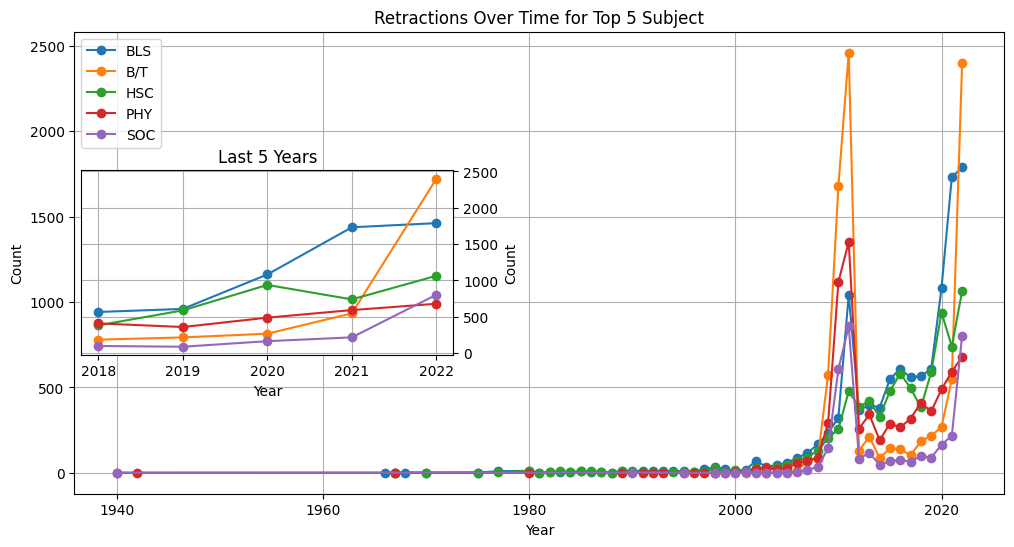

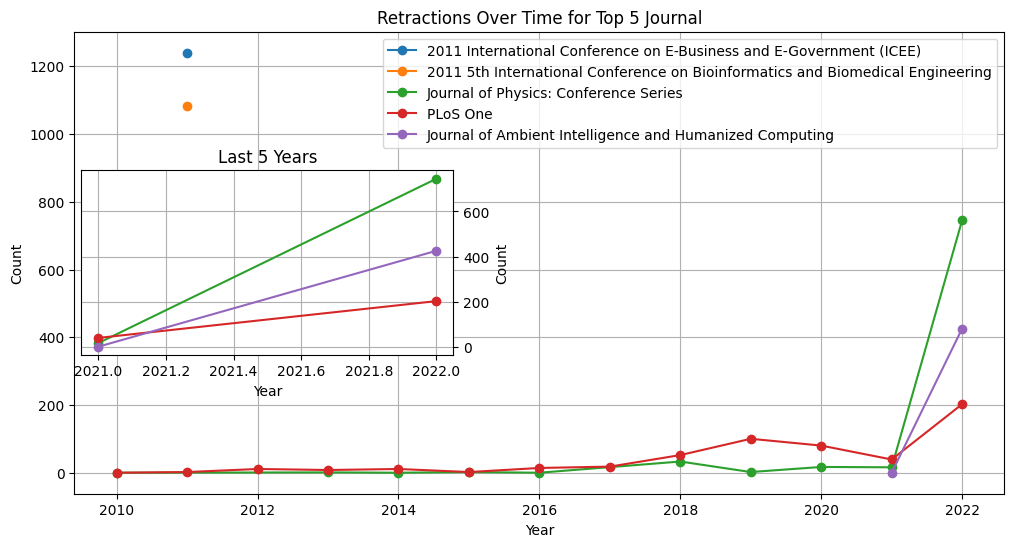

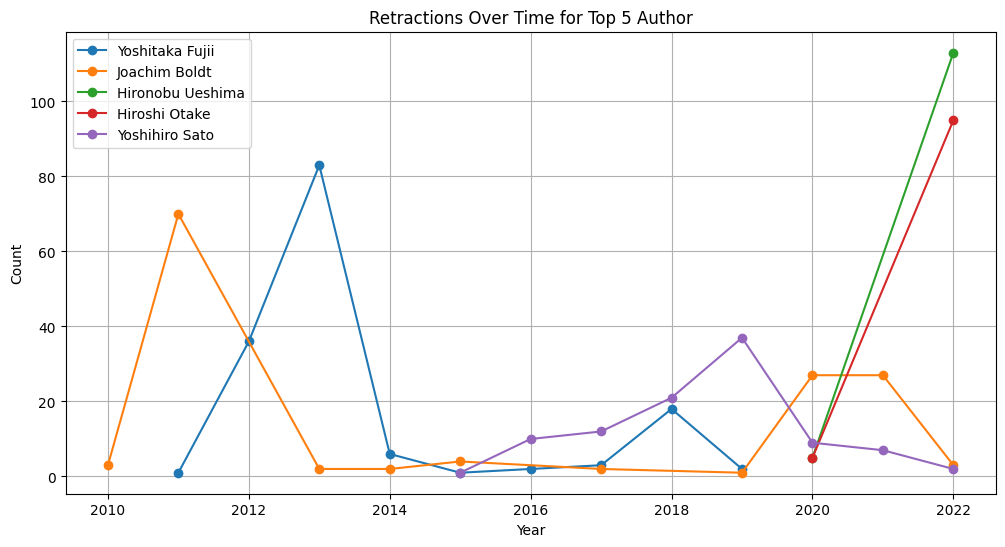

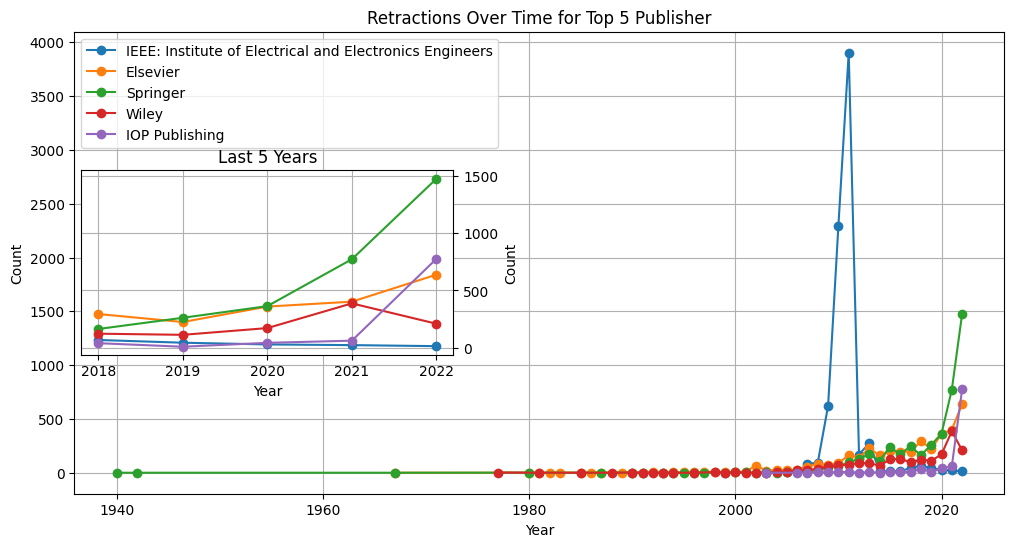

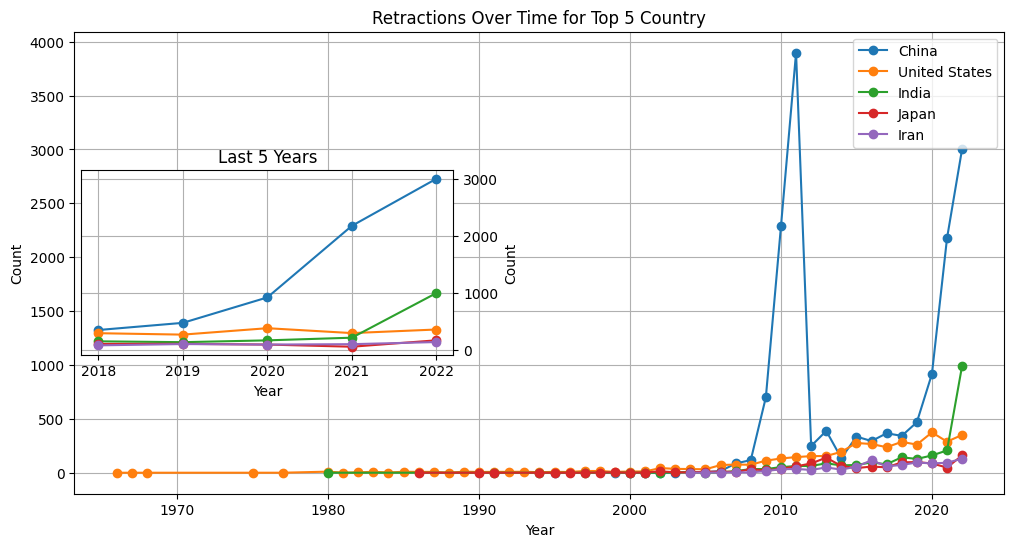

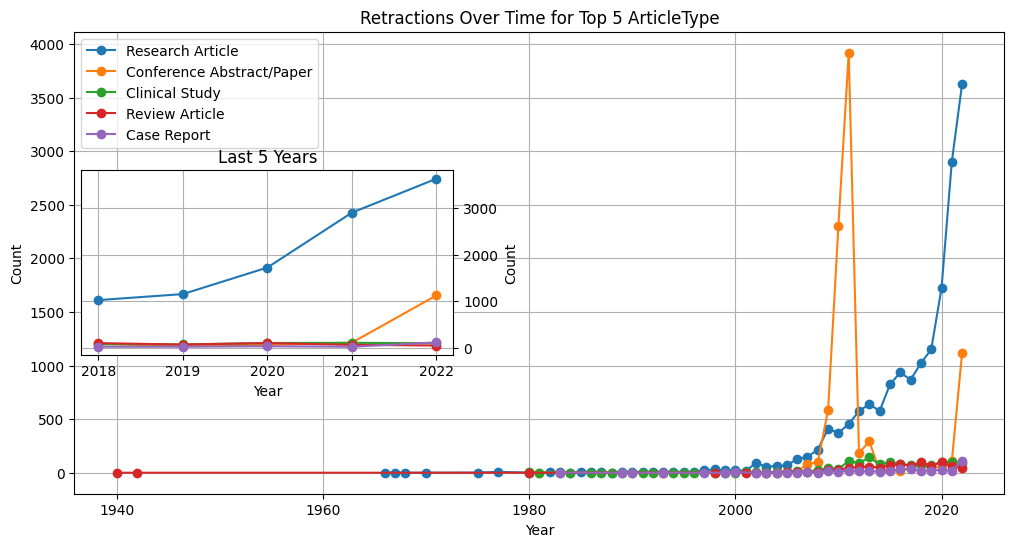

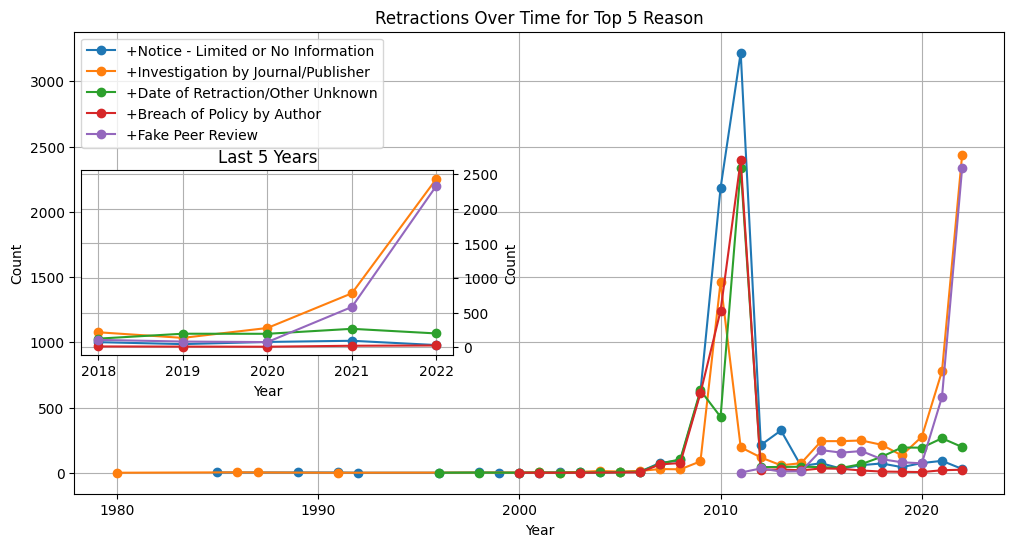

In [14]:
######### Time series Analysis by categorical columns ########################

df_filtered = df[df['RetractionDate'].dt.year < 2023]

def count_occurrences(column):
    occurrences = {}
    for cell in df_filtered[column].dropna():
        entries = re.split(r'[;,]', cell)
        for entry in entries:
            entry = entry.strip()
            if entry:
                if entry in occurrences:
                    occurrences[entry] += 1
                else:
                    occurrences[entry] = 1
    return occurrences

top_n_values = {
    'Subject': 5,
    'Journal': 5,
    'Author': 5,
    'Publisher': 5,
    'Country': 5,
    'ArticleType': 5,
    'Reason': 5
}

for column, top_n in top_n_values.items():
    occurrences = count_occurrences(column)

    top_values = sorted(occurrences, key=occurrences.get, reverse=True)[:top_n]

    fig, ax_main = plt.subplots(figsize=(12, 6))

    for value in top_values:
        df_value_filtered = df_filtered[df_filtered[column].str.contains(value, na=False, regex=False)].copy()

        df_value_filtered.loc[:, 'Year_Retraction'] = df_value_filtered['RetractionDate'].dt.year
        retractions_by_year = df_value_filtered['Year_Retraction'].value_counts().sort_index()

        ax_main.plot(retractions_by_year.index, retractions_by_year.values, marker='o', label=value)

    ax_main.set_title(f'Retractions Over Time for Top {top_n} {column}')
    ax_main.set_xlabel('Year')
    ax_main.set_ylabel('Count')
    ax_main.legend()
    ax_main.grid(True)

    if column != 'Author':
        ax_inset = inset_axes(ax_main, width="40%", height="40%", loc="center left")

        recent_years = retractions_by_year.index.sort_values()[-5:]

        for value in top_values:
            df_value_filtered = df_filtered[df_filtered[column].str.contains(value, na=False, regex=False)].copy()

            df_value_filtered.loc[:, 'Year_Retraction'] = df_value_filtered['RetractionDate'].dt.year
            retractions_by_year = df_value_filtered['Year_Retraction'].value_counts().sort_index()

            common_recent_years = recent_years.intersection(retractions_by_year.index)
            retractions_recent = retractions_by_year.loc[common_recent_years]

            ax_inset.plot(retractions_recent.index, retractions_recent.values, marker='o', label=value)

        ax_inset.yaxis.set_label_position("right")
        ax_inset.yaxis.tick_right()

        ax_inset.set_title('Last 5 Years')
        ax_inset.set_xlabel('Year')
        ax_inset.set_ylabel('Count')
        ax_inset.grid(True)

    plt.show()


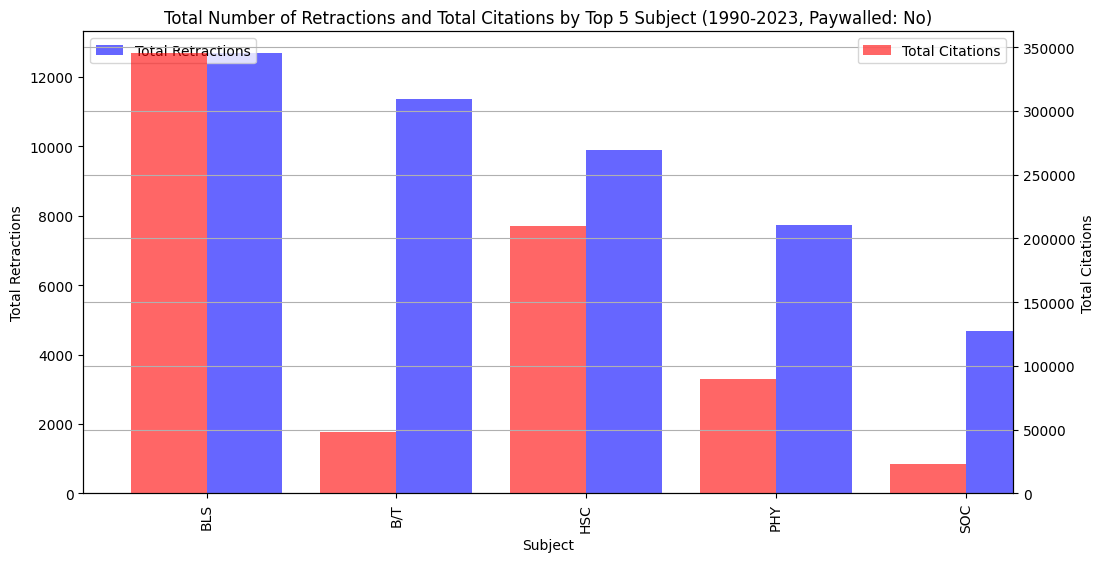

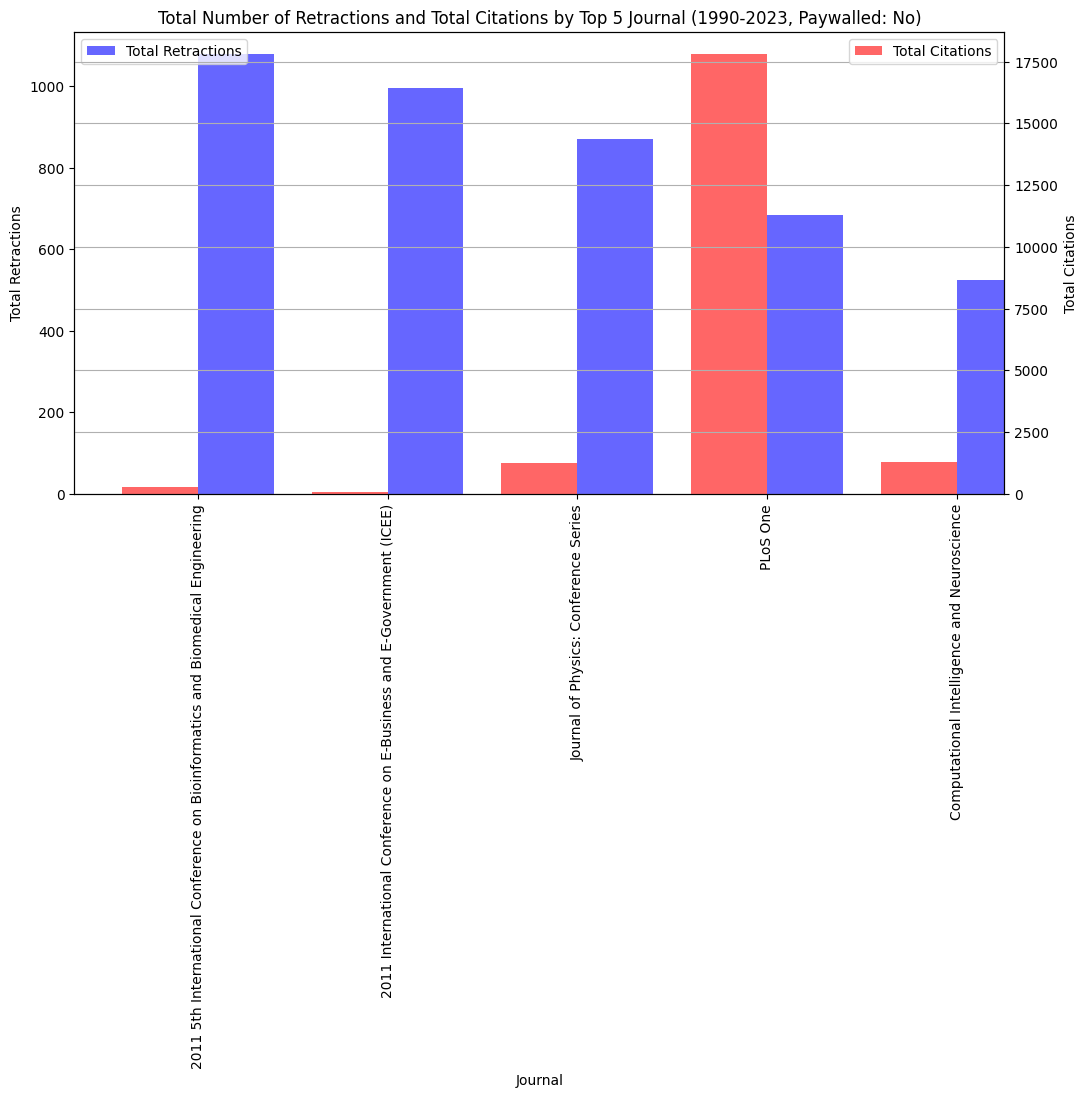

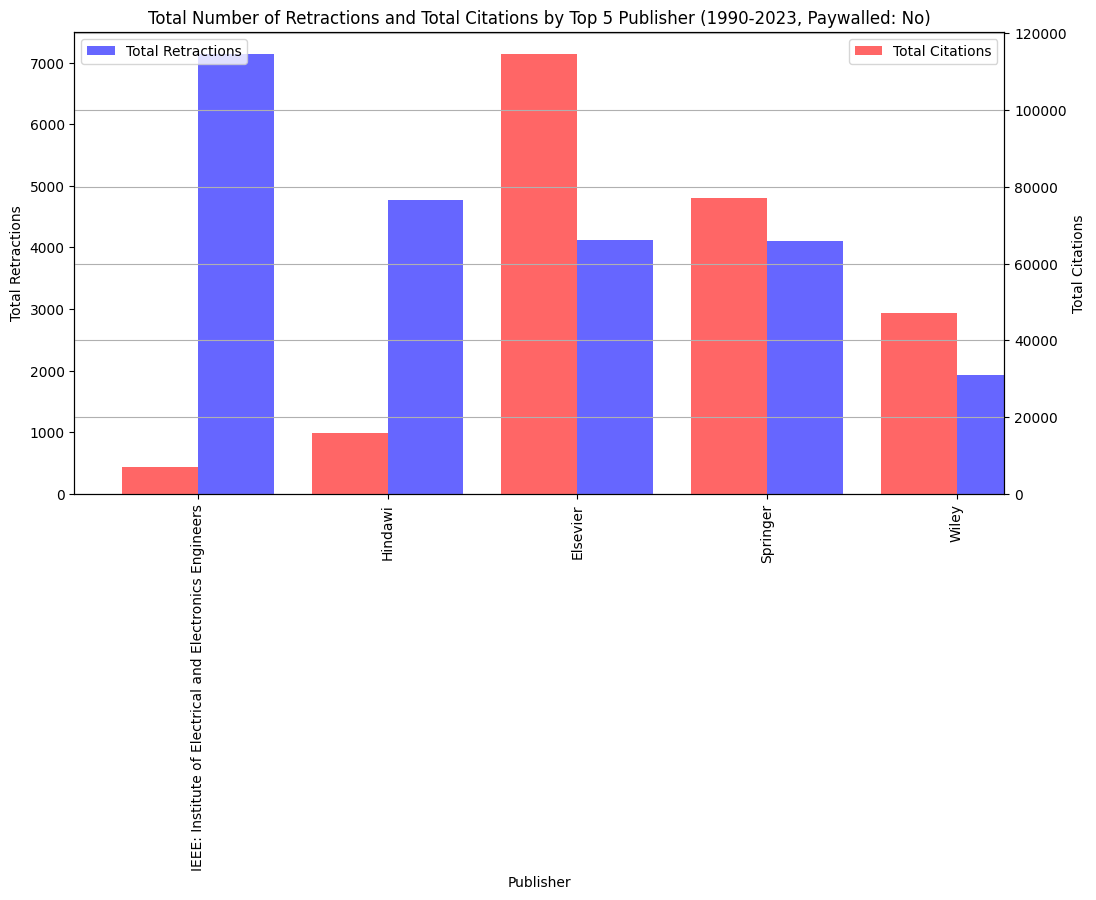

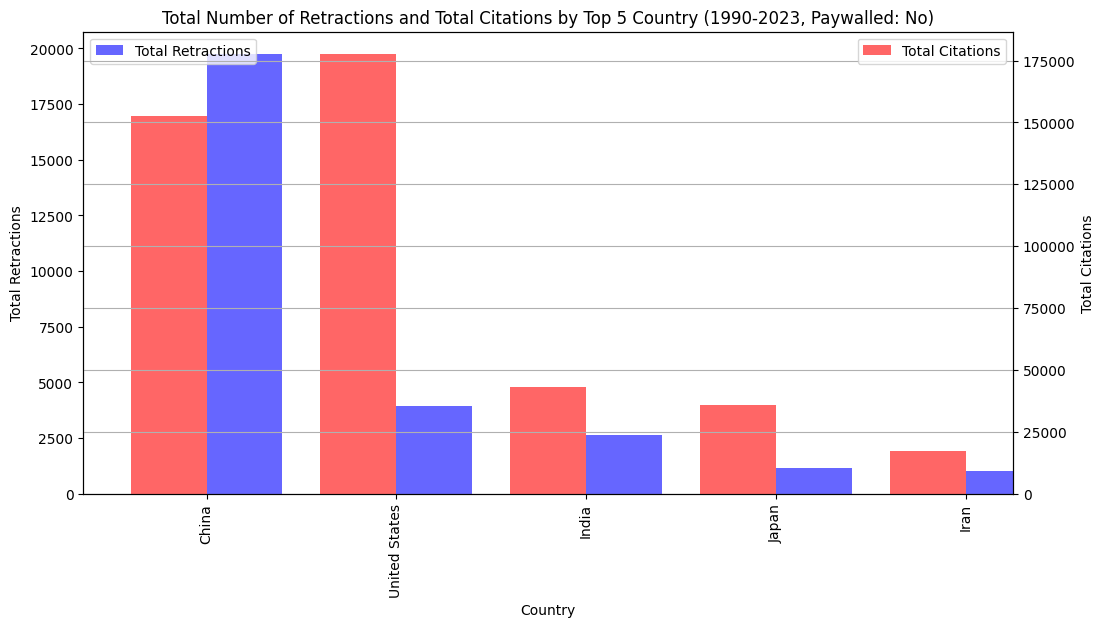

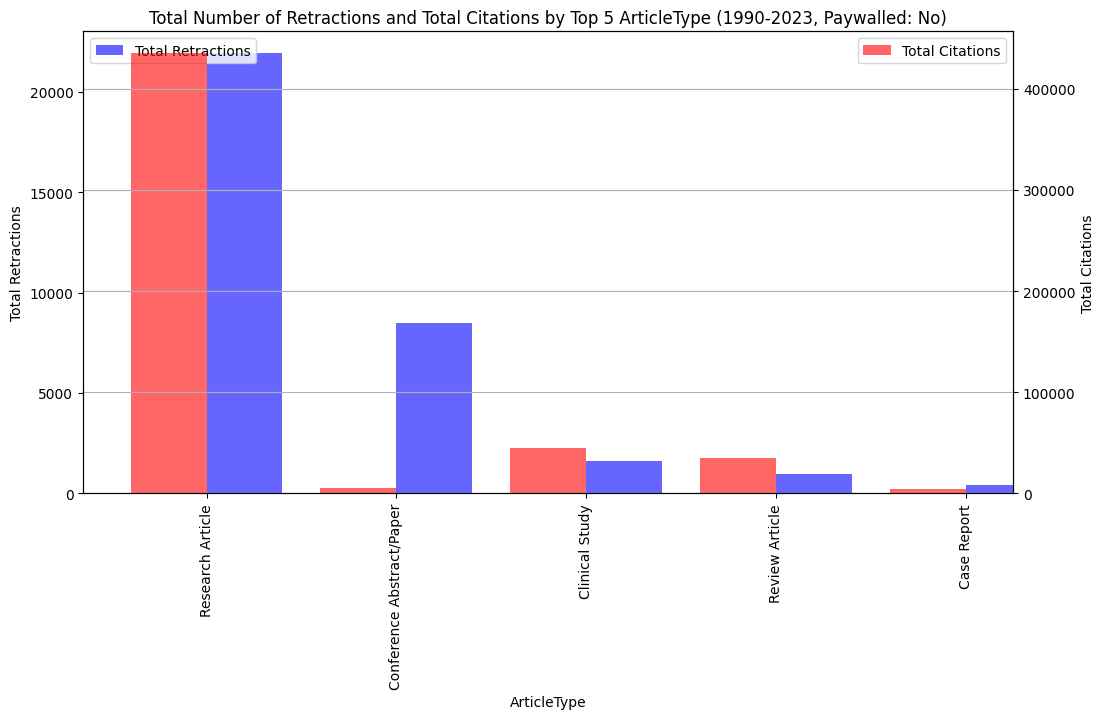

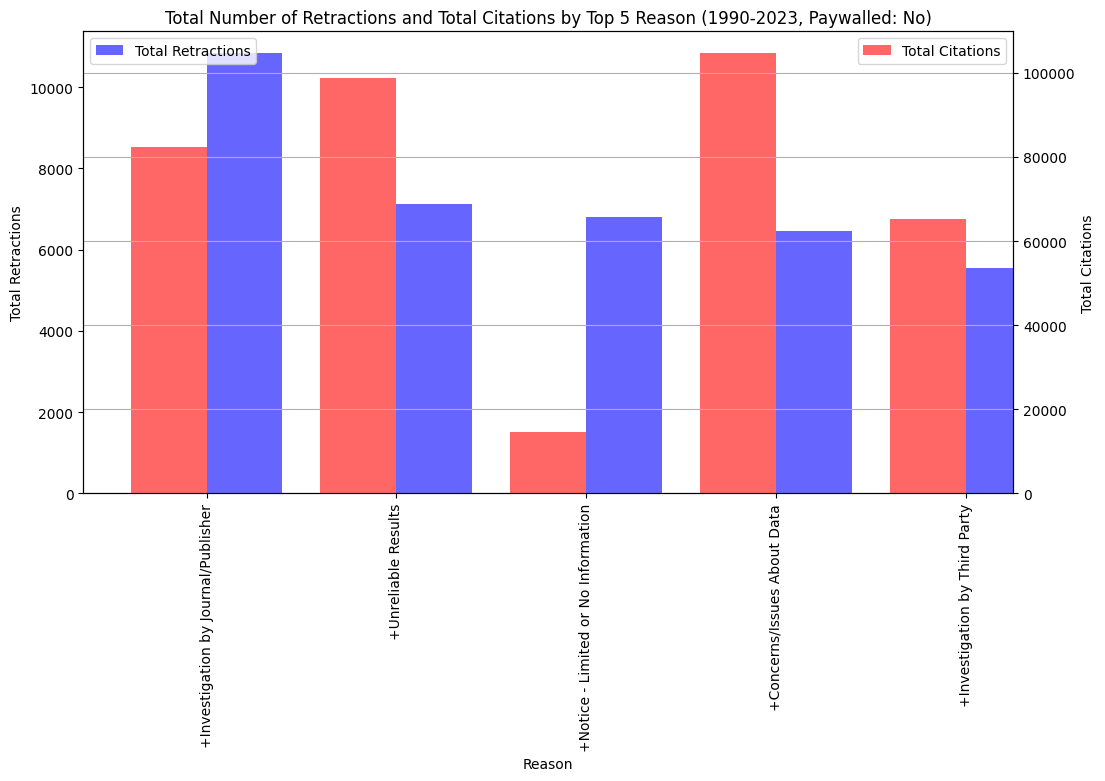

In [15]:

df_no_paywall = df[df['Paywalled'] == 'No']

def count_occurrences(df, column):
    occurrences = {}
    for cell in df[column].dropna():
        entries = re.split(r'[;,]', cell)
        for entry in entries:
            entry = entry.strip()
            if entry:
                if entry in occurrences:
                    occurrences[entry] += 1
                else:
                    occurrences[entry] = 1
    return occurrences

categorical_columns_no_paywall = ['Subject', 'Journal', 'Publisher', 'Country', 'ArticleType', 'Reason']

def plot_retractions_and_citations(df, category):
    occurrences = count_occurrences(df, category)

    top_values = sorted(occurrences, key=occurrences.get, reverse=True)[:5]

    df_top = df[df[category].apply(lambda x: any(val in str(x) for val in top_values))]

    retractions_by_category = df_top[category].apply(lambda x: [val for val in top_values if val in str(x)]).explode().value_counts()

    citations_by_category = {value: df_top[df_top[category].str.contains(value, na=False, regex=False)]['CitationCount'].sum() for value in top_values}
    citations_by_category = pd.Series(citations_by_category)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    retractions_by_category.plot(kind='bar', ax=ax1, color='blue', alpha=0.6, position=0, width=0.4, label='Total Retractions')
    ax1.set_ylabel('Total Retractions')
    ax1.set_xlabel(category)
    ax1.set_title(f'Total Number of Retractions and Total Citations by Top 5 {category} (1990-2023, Paywalled: No)')

    ax2 = ax1.twinx()

    citations_by_category.plot(kind='bar', ax=ax2, color='red', alpha=0.6, position=1, width=0.4, label='Total Citations')
    ax2.set_ylabel('Total Citations')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.show()

for category in categorical_columns_no_paywall:
    plot_retractions_and_citations(df_no_paywall, category)



**Predictive Analysis Using Feature Engineering**

In [6]:
import statsmodels.api

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [7]:
df['Reason_Count'] = df['Reason'].str.count('\;')
df_reason2=df[['Reason_Count','Reason']].groupby('Reason_Count').count()

In [8]:
df['Contains_Investigation'] = df['Reason'].str.contains('investigation', case=False).astype(int)
df['Contains_Unreliable'] = df['Reason'].str.contains('Unreliable', case=False).astype(int)
df['Contains_Data'] = df['Reason'].str.contains('Data', case=False).astype(int)
df['Contains_Date'] = df['Reason'].str.contains('Date', case=False).astype(int)
df['Contains_Breach'] = df['Reason'].str.contains('Breach', case=False).astype(int)
df['Contains_Fake'] = df['Reason'].str.contains('Fake', case=False).astype(int)
df['Contains_Limited'] = df['Reason'].str.contains('Limited', case=False).astype(int)
df['Contains_Duplication'] = df['Reason'].str.contains('Duplication', case=False).astype(int)
df['Contains_Referencing'] = df['Reason'].str.contains('Referencing', case=False).astype(int)
df['Contains_Peer'] = df['Reason'].str.contains('Peer', case=False).astype(int)
df['Contains_Randomly'] = df['Reason'].str.contains('Randomly', case=False).astype(int)
df['Contains_Plagiarism'] = df['Reason'].str.contains('Plagiarism', case=False).astype(int)
df['Contains_Mill'] = df['Reason'].str.contains('Mill', case=False).astype(int)
df['Contains_Misconduct'] = df['Reason'].str.contains('Misconduct', case=False).astype(int)
df['Contains_Upgrade'] = df['Reason'].str.contains('Upgrade', case=False).astype(int)
df['Contains_Falsification'] = df['Reason'].str.contains('Falsification', case=False).astype(int)
df['Contains_Unresponsive'] = df['Reason'].str.contains('Unresponsive', case=False).astype(int)
df['Contains_Image'] = df['Reason'].str.contains('Image', case=False).astype(int)
df['Contains_Approval'] = df['Reason'].str.contains('Approval', case=False).astype(int)
df['Contains_Authorship'] = df['Reason'].str.contains('Authorship', case=False).astype(int)
df['Contains_Withdrawal'] = df['Reason'].str.contains('Withdrawal', case=False).astype(int)


df_split = df['Reason'].str.split(';', expand=True)
for i in df_split.columns:
    if i==df_split.columns[0]:
        df_allreason=pd.concat([df_split[0],df_split[1]])
    elif i==df_split.columns[-3]:
        df_allreason=pd.concat([df_allreason,df_split[i+2]])
        break
    else:
        df_allreason=pd.concat([df_allreason,df_split[i+2]])


In [9]:
df_clustering=df[['Reason_Count', 'Contains_Investigation',
       'Contains_Unreliable', 'Contains_Data', 'Contains_Date',
       'Contains_Breach', 'Contains_Fake', 'Contains_Limited',
       'Contains_Duplication', 'Contains_Referencing', 'Contains_Peer',
       'Contains_Randomly', 'Contains_Plagiarism', 'Contains_Mill',
       'Contains_Misconduct', 'Contains_Upgrade', 'Contains_Falsification',
       'Contains_Unresponsive', 'Contains_Image', 'Contains_Approval',
       'Contains_Authorship', 'Contains_Withdrawal']]

std_scaler = preprocessing.StandardScaler()
df_std = std_scaler.fit_transform(df_clustering)

In [10]:
pca = PCA(0.90).fit(df_std)
print("90%% variance is explained by: %.d components." % pca.n_components_)

90% variance is explained by: 15 components.


In [11]:
pca = PCA(n_components=15)
df_clustering = pca.fit_transform(df_std)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


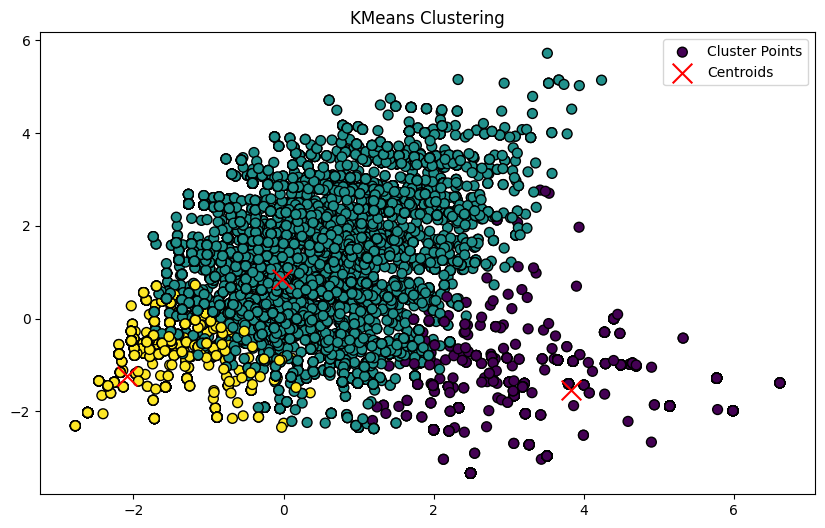

In [24]:
model = KMeans(n_clusters=3, random_state=0)
clusters = model.fit_predict(df_clustering)
centroids = model.cluster_centers_
plt.figure(figsize=(10, 6))
plt.scatter(df_clustering[:, 0], df_clustering[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='black', s=50, label='Cluster Points')

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title('KMeans Clustering')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


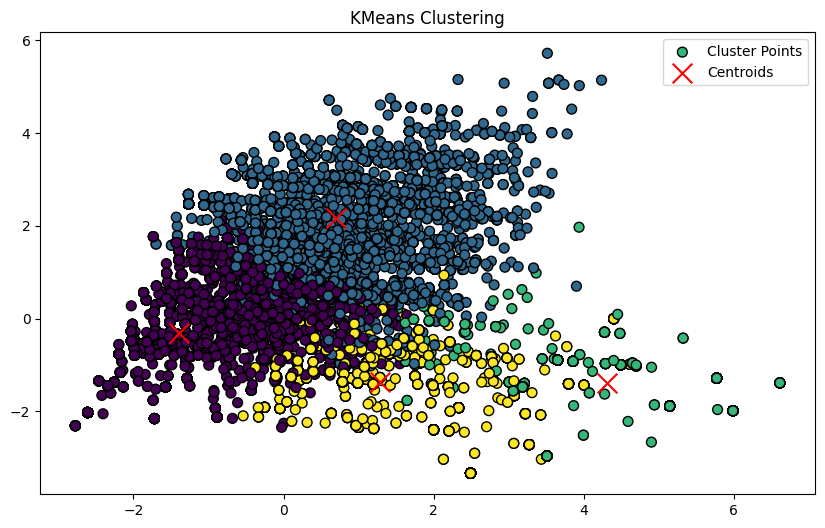

In [25]:
model = KMeans(n_clusters=4, random_state=0)
clusters = model.fit_predict(df_clustering)
centroids = model.cluster_centers_
plt.figure(figsize=(10, 6))
plt.scatter(df_clustering[:, 0], df_clustering[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='black', s=50, label='Cluster Points')

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title('KMeans Clustering')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


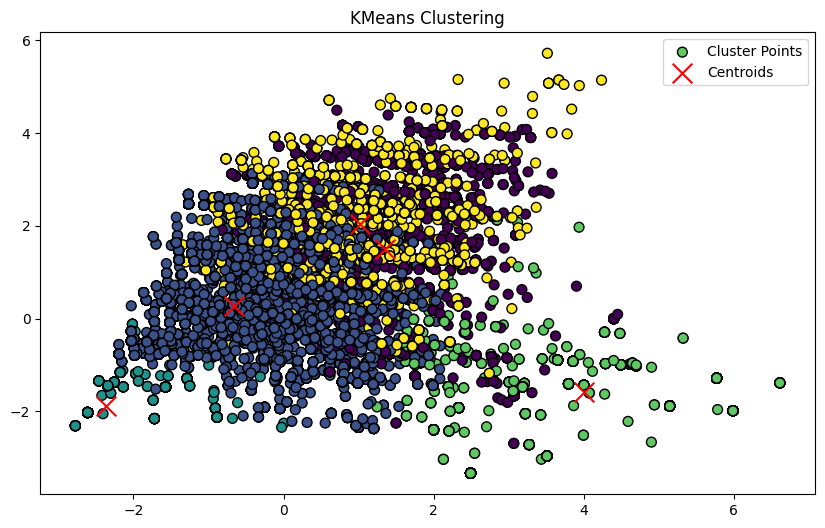

In [26]:
model = KMeans(n_clusters=5, random_state=0)
clusters = model.fit_predict(df_clustering)
centroids = model.cluster_centers_
plt.figure(figsize=(10, 6))
plt.scatter(df_clustering[:, 0], df_clustering[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='black', s=50, label='Cluster Points')

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title('KMeans Clustering')
plt.legend()
plt.show()

In [27]:
print("Dimensions of df_clustering:", df_clustering.shape)
print("Dimensions of clusters array:", len(clusters))



Dimensions of df_clustering: (35213, 15)
Dimensions of clusters array: 35213


In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Reason_encoded'] = label_encoder.fit_transform(df['Reason'])


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

features = ['Reason_Count', 'Contains_Investigation', 'Contains_Unreliable',
            'Contains_Data', 'Contains_Date', 'Contains_Breach', 'Contains_Fake',
            'Contains_Limited', 'Contains_Duplication', 'Contains_Referencing',
            'Contains_Peer', 'Contains_Randomly', 'Contains_Plagiarism', 'Contains_Mill',
            'Contains_Misconduct', 'Contains_Upgrade', 'Contains_Falsification',
            'Contains_Unresponsive', 'Contains_Image', 'Contains_Approval',
            'Contains_Authorship', 'Contains_Withdrawal']
target_variable = 'Reason'

X = df[features]
y = df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4615
Precision: 0.2732
Recall: 0.4615
F1 Score: 0.3330


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

features = ['Reason_Count', 'Contains_Investigation', 'Contains_Unreliable',
            'Contains_Data', 'Contains_Date', 'Contains_Breach', 'Contains_Fake',
            'Contains_Limited', 'Contains_Duplication', 'Contains_Referencing',
            'Contains_Peer', 'Contains_Randomly', 'Contains_Plagiarism', 'Contains_Mill',
            'Contains_Misconduct', 'Contains_Upgrade', 'Contains_Falsification',
            'Contains_Unresponsive', 'Contains_Image', 'Contains_Approval',
            'Contains_Authorship', 'Contains_Withdrawal']
target_variable = 'Reason'

X = df[features]
y = df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Model evaluation: Logistic Regression
Accuracy: 0.9017464148800227
Precision: 0.8313364055299539
Recall: 0.6392629340892984
F1 Score: 0.7227564102564102


In [20]:
from sklearn.preprocessing import LabelEncoder


label_encoders = {}
for column in ['Subject', 'Journal', 'Publisher', 'Country', 'CitationCount', 'Paywalled']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Define features and target
features = ['Subject', 'Journal', 'Publisher', 'Country', 'CitationCount', 'Paywalled']
X = df[features]
y = df['Reason'] = le.fit_transform(df['Reason'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Model evaluation: Logistic Regression")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Model evaluation: Logistic Regression
Accuracy: 0.8174073548203891
Precision: 0.8473908762717427
Recall: 0.7587422862180428
F1 Score: 0.8006201550387597
